In [456]:
# Import four main libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import metrics and time
from sklearn import metrics
from time import time

#import necessary library for random oversampling
from imblearn.over_sampling import RandomOverSampler 

# Import modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.tree import plot_tree # visualising the DT tree

# Few ensemble models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [366]:
## Metrics function

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [368]:
# Load in the dataset
df = pd.read_csv('swan_consulting_data.csv')

In [370]:
pd.set_option('display.max_columns', None)

In [372]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [374]:
# Mapping columns to get binary results
def columns_binary(x):
    if x == 'Yes':
        return 1
    else:
        return 0

def feature_eng(df):
    # Drop non-useful columns
    df = df.drop(columns = ['CustomerID', 'Country', 'State', 'Churn Label'], axis = 1) # We already have Churn Value which is already a numerical
    
    
    # Churn reason column -- Handle nulls
    df['Churn Reason'] = df['Churn Reason'].fillna('Did not churn')
    
    
    # Change yes/no(including: No internet/Phone services) to binary
    df['Senior Citizen'] = df['Senior Citizen'].apply(columns_binary)
    df['Partner'] = df['Partner'].apply(columns_binary)
    df['Dependents'] = df['Dependents'].apply(columns_binary)
    df['Phone Service'] = df['Phone Service'].apply(columns_binary)
    df['Multiple Lines'] = df['Multiple Lines'].apply(columns_binary)
    df['Online Security'] = df['Online Security'].apply(columns_binary)
    df['Device Protection'] = df['Device Protection'].apply(columns_binary)
    df['Online Backup'] = df['Online Backup'].apply(columns_binary)
    df['Tech Support'] = df['Tech Support'].apply(columns_binary)
    df['Streaming TV'] = df['Streaming TV'].apply(columns_binary)
    df['Streaming Movies'] = df['Streaming Movies'].apply(columns_binary)
    df['Paperless Billing'] = df['Paperless Billing'].apply(columns_binary)

    # Changing columns with only two results to numericals
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
    
    # OHE columns
    df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = True, prefix = 'Internet Service', dtype=int)
    df = pd.get_dummies(df, columns = ['Contract'], drop_first = True, prefix = 'Contract', dtype=int)
    df = pd.get_dummies(df, columns = ['Payment Method'], drop_first = True, prefix = 'Payment Method', dtype=int)
    # df = pd.get_dummies(df, columns = ['Churn Reason'], drop_first = True, prefix = 'Churn Reason', dtype=int)

    
    # Scaling 
    # continuous_cols = ['Monthly Charges', 'Total Charges', 'Tenure Months']
    # Standard
    # df[continuous_cols] = scaler_standard.fit_transform(df[continuous_cols])
    # Min-Max Scaling
    # df['continuous_cols'] = scaler_minmax.fit_transform(df['continuous_cols'])
    # Robust
    # df['continuous_cols'] = scaler_robust.fit_transform(df['continuous_cols'])

    
    
    # Upscale / Downscale data to get a balanced churn/non-churned split
    
    
    
    return df

In [376]:
df_fe = feature_eng(df)


In [378]:
df_fe.info() # Should have no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Count                                   7043 non-null   int64  
 1   City                                    7043 non-null   object 
 2   Zip Code                                7043 non-null   int64  
 3   Lat Long                                7043 non-null   object 
 4   Latitude                                7043 non-null   float64
 5   Longitude                               7043 non-null   float64
 6   Gender                                  7043 non-null   int64  
 7   Senior Citizen                          7043 non-null   int64  
 8   Partner                                 7043 non-null   int64  
 9   Dependents                              7043 non-null   int64  
 10  Tenure Months                           7043 non-null   int6

In [380]:
df_fe['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [382]:
df_fe.head()

,Count,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Total Charges,Churn Value,Churn Reason,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,Competitor made better offer,0,0,0,0,0,0,1
1,1,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,Moved,1,0,0,0,0,1,0
2,1,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,820.5,1,Moved,1,0,0,0,0,1,0
3,1,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,3046.05,1,Moved,1,0,0,0,0,1,0
4,1,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,5036.3,1,Competitor had better devices,1,0,0,0,0,0,0


In [384]:
def oversample(X,y):
    ''' X = a dataframe containing only the features of the data
        Y = a dataframe containing only the target
    '''
    ros = RandomOverSampler(sampling_strategy='not majority') #define random oversample model
    X_res, y_res = ros.fit_resample(X,y) #fit the random oversample to the data
    return X_res, y_res #return resampled feature and target dataframes

In [386]:
X = df_fe[feature_cols] # Dataframe which holds all the features
y = df_fe['Churn Value'] # The target to predict

In [388]:
X_res, y_res = oversample(X,y)

In [390]:
# StepWise Feature Columns
feature_cols_refined = ['Contract_Two year',
 'Contract_One year',
 'Internet Service_Fiber optic',
 'Dependents',
 'Tenure Months',
 'Internet Service_No',
 'Online Security',
 'Payment Method_Electronic check',
 'Streaming Movies',
 'Tech Support',
 'Paperless Billing',
 'Partner',
 'Streaming TV',
 'Multiple Lines',
 'Monthly Charges']

In [392]:
feature_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents','Tenure Months',
                'Phone Service', 'Multiple Lines', 'Online Security',
                'Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies',
                'Paperless Billing','Monthly Charges',
                'Internet Service_Fiber optic', 'Internet Service_No', 'Contract_One year', 'Contract_Two year',
                'Payment Method_Credit card (automatic)','Payment Method_Electronic check','Payment Method_Mailed check']

# Train/test split data
X_train, X_test, y_train, y_test = train_test_split(X_res, # features
                                                    y_res, # target
                                                    test_size = 0.2, # The % allocated to test
                                                    random_state = 56) # Random state - python will retain the shuffle of dataset

In [394]:
X_train.dtypes

Gender                                      int64
Senior Citizen                              int64
Partner                                     int64
Dependents                                  int64
Tenure Months                               int64
Phone Service                               int64
Multiple Lines                              int64
Online Security                             int64
Online Backup                               int64
Device Protection                           int64
Tech Support                                int64
Streaming TV                                int64
Streaming Movies                            int64
Paperless Billing                           int64
Monthly Charges                           float64
Internet Service_Fiber optic                int64
Internet Service_No                         int64
Contract_One year                           int64
Contract_Two year                           int64
Payment Method_Credit card (automatic)      int64


In [396]:
y_train

42      1
9148    1
2147    0
9457    1
4599    0
       ..
9338    1
9451    1
3264    0
399     1
2532    0
Name: Churn Value, Length: 8278, dtype: int64

In [398]:
# To check if there is variation in performance
# Create a decision tree
tree = DecisionTreeClassifier(random_state=124)

# Apply cross validation on the tree on the data
# Simulates what would happen if we fit the tree on the data with the following parameters
scores = cross_val_score(tree, # tree itself
                         X_train, # Feature
                         y_train, # Target
                         cv = 5) # The value of K: number of folds

If they differ a lot - it tells us that our model is overfitted to the data! Ideally, we'd want similar scores!

In [401]:
# Check the scores
scores

array([0.85809179, 0.81944444, 0.84903382, 0.85679758, 0.85619335])

In [403]:
# Mean score
sum(scores) / len(scores)

0.8479121969730141

In [464]:
rf = RandomForestClassifier(n_estimators=50) # Random Forests

## Check respective cross validation scores if overfitting need to tune as shown below

rf_score = cross_val_score(rf, X_train, y_train, cv=5)

#Step 1: Select parameters
rf_params = {
    'n_estimators': [100, 150, 200], # 3 options
    'max_depth': [1, 2, 3, 4, 5, 10, 15], # 6 options
}

# Create a grid search object
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose = 1) # k = 5

# Fit grid search on the training set
gs.fit(X_train, y_train)

# Save my best model as a random forest model
best_rf = gs.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [465]:
## Predict on Train
y_pred = best_rf.predict(X_train)
## Check Accuracy, Precision, Recall & F1
apr(y_pred, y_train)

Accuracy:0.9673834259482967
Precision:0.9401592718998862
Recall:0.9983087702343562
F1:0.9683618467307242


(0.9673834259482967,
 0.9401592718998862,
 0.9983087702343562,
 0.9683618467307242)

In [466]:
## Predict on Test
# Use the model to predict on X_test
y_pred_test = best_rf.predict(X_test)

## Check Accuracy, Precision, Recall & F1
apr(y_pred_test, y_test)

Accuracy:0.8830917874396135
Precision:0.8380221653878943
Recall:0.9497584541062802
F1:0.8903985507246377


(0.8830917874396135,
 0.8380221653878943,
 0.9497584541062802,
 0.8903985507246377)

In [467]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 200}

In [468]:
# Valuable metrics

# Get best accuracy score
print(gs.best_score_)

# Fetches best parameters
gs.best_params_

## How well the model does
gs.score(X_train, y_train)

# Explainability of Random Forest/Decision Trees - importance features
print(list(zip(X_train.columns, best_rf.feature_importances_)))

0.8742458076097902
[('Gender', 0.026711693395167494), ('Senior Citizen', 0.019217932856255792), ('Partner', 0.027930159221861487), ('Dependents', 0.05875381995054657), ('Tenure Months', 0.22964657927404517), ('Phone Service', 0.008912742894070687), ('Multiple Lines', 0.019493002241802247), ('Online Security', 0.02773843571428346), ('Online Backup', 0.02264424253338819), ('Device Protection', 0.01946378016413264), ('Tech Support', 0.02571070985959485), ('Streaming TV', 0.017627843129944684), ('Streaming Movies', 0.019716978647984783), ('Paperless Billing', 0.029541547456821207), ('Monthly Charges', 0.18530833480661404), ('Internet Service_Fiber optic', 0.05094020143259958), ('Internet Service_No', 0.02593465864159203), ('Contract_One year', 0.03919523639396463), ('Contract_Two year', 0.07483884688083733), ('Payment Method_Credit card (automatic)', 0.016227802060755133), ('Payment Method_Electronic check', 0.04047627732556051), ('Payment Method_Mailed check', 0.013969175118177446)]


In [469]:
## How well the model does
gs.score(X_train, y_train)

0.9673834259482967

In [470]:
gs.score(X_test, y_test)

0.8830917874396135

In [478]:
# Probabilities
# df_fe is the clen dataset
# df_fe_prob = df_fe[df_fe['Churn Value']== 1].copy() need to be same length for proba so will filter out later
df_fe_prob = df_fe.copy()
df_fe_prob 

,Count,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Total Charges,Churn Value,Churn Reason,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,Competitor made better offer,0,0,0,0,0,0,1
1,1,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,Moved,1,0,0,0,0,1,0
2,1,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,820.5,1,Moved,1,0,0,0,0,1,0
3,1,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,3046.05,1,Moved,1,0,0,0,0,1,0
4,1,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,5036.3,1,Competitor had better devices,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,1,0,0,0,72,1,0,0,0,0,0,0,0,1,21.15,1419.4,0,Did not churn,0,1,0,1,0,0,0
7039,1,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,0,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,1990.5,0,Did not churn,0,0,1,0,0,0,1
7040,1,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,1,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,7362.9,0,Did not churn,1,0,1,0,1,0,0
7041,1,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,1,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,346.45,0,Did not churn,0,0,0,0,0,1,0


In [480]:
df_fe_prob = df_fe_prob[feature_cols]

In [482]:
df_fe_prob

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,0,0,0,0,0,0,1
1,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,1,0,0,0,0,1,0
2,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,1,0,0,0,0,1,0
3,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,1,0,0,0,0,1,0
4,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,72,1,0,0,0,0,0,0,0,1,21.15,0,1,0,1,0,0,0
7039,0,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,0,0,1,0,0,0,1
7040,1,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,1,0,1,0,1,0,0
7041,1,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,0,0,0,0,0,1,0


In [484]:
best_rf.predict_proba(df_fe_prob)[:,1].shape

(7043,)

In [486]:
df_fe_prob[['prob_not_churn', 'prob_churn']] =  best_rf.predict_proba(df_fe_prob)

/var/folders/3b/ldv6cnd11flfp1qdv9w4wc2c0000gn/T/ipykernel_41809/1613517466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fe_prob[['prob_not_churn', 'prob_churn']] =  best_rf.predict_proba(df_fe_prob)
/var/folders/3b/ldv6cnd11flfp1qdv9w4wc2c0000gn/T/ipykernel_41809/1613517466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fe_prob[['prob_not_churn', 'prob_churn']] =  best_rf.predict_proba(df_fe_prob)


In [488]:
df_fe_prob

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_not_churn,prob_churn
0,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,0,0,0,0,0,0,1,0.167415,0.832585
1,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,1,0,0,0,0,1,0,0.041398,0.958602
2,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,1,0,0,0,0,1,0,0.023419,0.976581
3,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,1,0,0,0,0,1,0,0.054979,0.945021
4,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,1,0,0,0,0,0,0,0.130301,0.869699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,72,1,0,0,0,0,0,0,0,1,21.15,0,1,0,1,0,0,0,0.995000,0.005000
7039,0,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,0,0,1,0,0,0,1,0.975000,0.025000
7040,1,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,1,0,1,0,1,0,0,0.981667,0.018333
7041,1,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,0,0,0,0,0,1,0,0.778689,0.221311


In [490]:
df_fe_prob['Churn Value'] = df_fe['Churn Value']

/var/folders/3b/ldv6cnd11flfp1qdv9w4wc2c0000gn/T/ipykernel_41809/3900244076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fe_prob['Churn Value'] = df_fe['Churn Value']


In [492]:
df_fe_prob

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_not_churn,prob_churn,Churn Value
0,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,0,0,0,0,0,0,1,0.167415,0.832585,1
1,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,1,0,0,0,0,1,0,0.041398,0.958602,1
2,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,1,0,0,0,0,1,0,0.023419,0.976581,1
3,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,1,0,0,0,0,1,0,0.054979,0.945021,1
4,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,1,0,0,0,0,0,0,0.130301,0.869699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,72,1,0,0,0,0,0,0,0,1,21.15,0,1,0,1,0,0,0,0.995000,0.005000,0
7039,0,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,0,0,1,0,0,0,1,0.975000,0.025000,0
7040,1,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,1,0,1,0,1,0,0,0.981667,0.018333,0
7041,1,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,0,0,0,0,0,1,0,0.778689,0.221311,0


In [494]:
# False Negative
df_fe_prob[(df_fe_prob['Churn Value'] == 1) & (df_fe_prob['prob_churn'] < 0.5)]

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_not_churn,prob_churn,Churn Value
10,1,0,0,0,17,1,0,0,0,0,0,1,1,1,64.70,0,0,0,0,0,0,1,0.633566,0.366434,1
27,1,0,1,1,10,1,1,1,0,0,0,1,1,1,100.25,1,0,0,0,0,1,0,0.548077,0.451923,1
44,1,0,0,0,1,0,0,0,1,0,0,0,0,0,29.95,0,0,0,0,0,0,0,0.547809,0.452191,1
248,0,0,0,0,71,1,1,1,0,1,1,1,1,1,108.05,1,0,0,1,0,1,0,0.796597,0.203403,1
303,0,0,1,0,60,1,0,0,1,0,0,1,1,1,94.40,1,0,1,0,0,1,0,0.613232,0.386768,1
348,0,0,1,0,59,1,1,0,0,1,0,1,1,1,99.50,1,0,1,0,0,0,0,0.713127,0.286873,1
359,0,0,0,0,4,1,1,0,1,0,0,0,0,0,78.45,1,0,0,0,0,1,0,0.510498,0.489502,1
361,0,0,1,0,59,0,0,0,1,0,0,0,1,1,41.05,0,0,0,0,0,0,0,0.702353,0.297647,1
465,1,0,0,0,4,1,0,0,0,0,0,0,0,0,20.35,0,1,0,0,0,0,1,0.504789,0.495211,1
538,0,0,1,0,67,1,0,1,1,0,0,0,1,1,90.60,1,0,1,0,1,0,0,0.871528,0.128472,1


In [496]:
# False Positive
df_fe_prob[(df_fe_prob['Churn Value'] == 0) & (df_fe_prob['prob_churn'] > 0.5)]

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_not_churn,prob_churn,Churn Value
1882,1,0,0,0,21,1,0,0,1,1,0,0,1,1,90.05,1,0,0,0,0,1,0,0.260311,0.739689,0
1889,0,1,1,0,2,1,0,0,0,1,0,1,1,1,95.50,1,0,0,0,1,0,0,0.195796,0.804204,0
1891,0,0,0,0,1,1,0,0,0,0,0,0,0,0,20.20,0,1,0,0,0,0,0,0.310686,0.689314,0
1900,1,0,0,0,49,1,1,0,0,0,0,0,1,1,84.50,1,0,0,0,0,1,0,0.475955,0.524045,0
1911,1,0,1,0,47,1,1,0,0,1,0,1,1,1,100.50,1,0,0,0,0,1,0,0.374284,0.625716,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6957,0,0,0,0,3,1,0,0,1,0,0,0,0,0,74.45,1,0,0,0,1,0,0,0.378159,0.621841,0
6981,1,0,0,0,12,1,0,0,0,0,0,0,0,1,45.05,0,0,0,0,0,1,0,0.345152,0.654848,0
6986,1,1,1,0,42,1,1,0,1,1,0,1,0,1,95.55,1,0,0,0,0,1,0,0.440305,0.559695,0
7011,1,0,0,0,13,1,0,0,0,0,0,0,1,1,80.50,1,0,0,0,0,1,0,0.296278,0.703722,0


In [498]:
best_rf.estimators_

[DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=811633884),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=1313639023),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=1798074494),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=681082358),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=1257778743),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=827003494),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=778723157),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=283961130),
 DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                        random_state=2039225564),
 DecisionTreeClassifier(

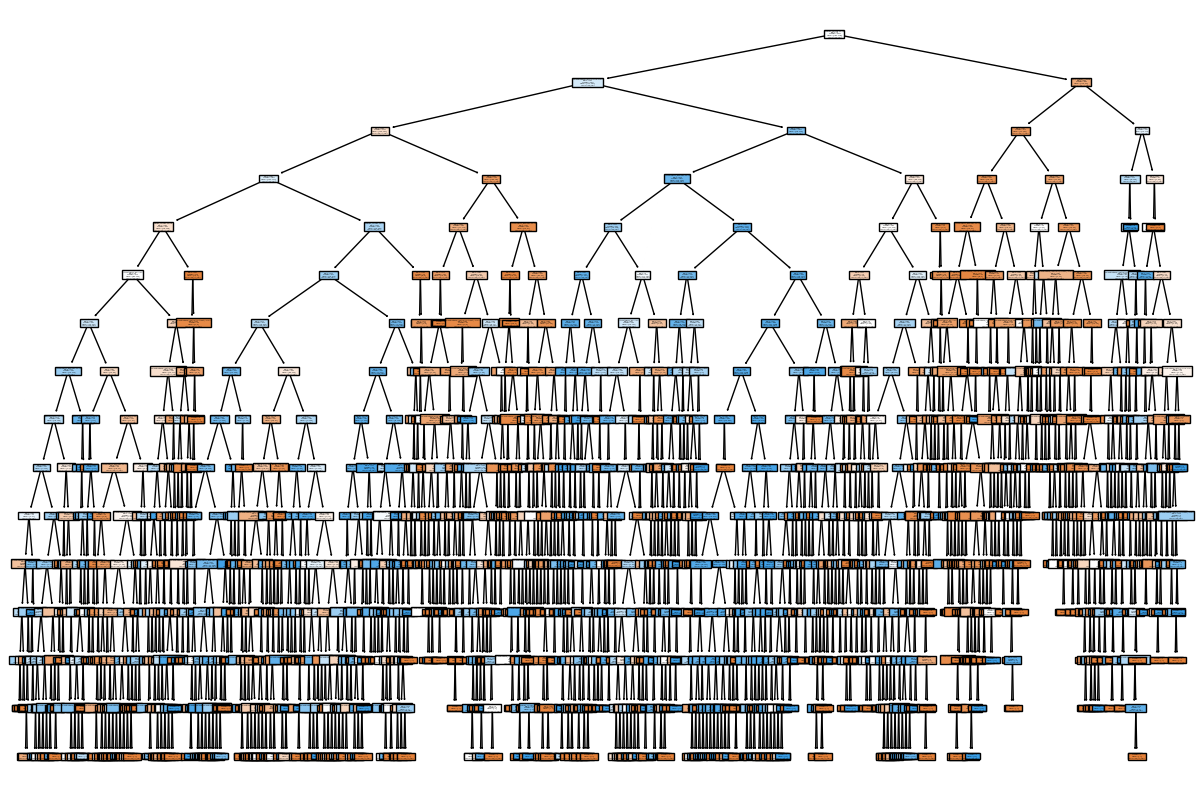

In [500]:
import random

# Get the list of decision trees in the random forest
trees = best_rf.estimators_

# Select a random decision tree from the list
random_tree = random.choice(trees)

# Plot the selected decision tree
fig = plt.figure(figsize=(15, 10))
plot_tree(random_tree, feature_names=feature_cols, class_names=['prob_not_churn', 'prob_churn'], filled=True)
plt.show()